# Credit Card Fraud
## MSIS 522: Presentation Project


In [ ]:
#Data Extraction, Cleaning, and Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from collections import Counter
!pip install kagglehub
from imblearn.under_sampling import NearMiss
import sklearn.model_selection as model_selection
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_val_predict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [ ]:
import kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:02<00:00, 30.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [ ]:
csv_file = os.path.join(path, "creditcard.csv")

In [ ]:
df = pd.read_csv(csv_file)
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
#Data Analysis: Known Features

In [ ]:
print('Fraud is', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Regular Transactions are', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Fraud is 0.17 % of the dataset
Regular Transactions are 99.83 % of the dataset


In [ ]:
print("Fraud:")
print(df.Time[df.Class == 1].describe())
print()
print("Regular Transactions:")
print(df.Time[df.Class == 0].describe())

Fraud:
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Regular Transactions:
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


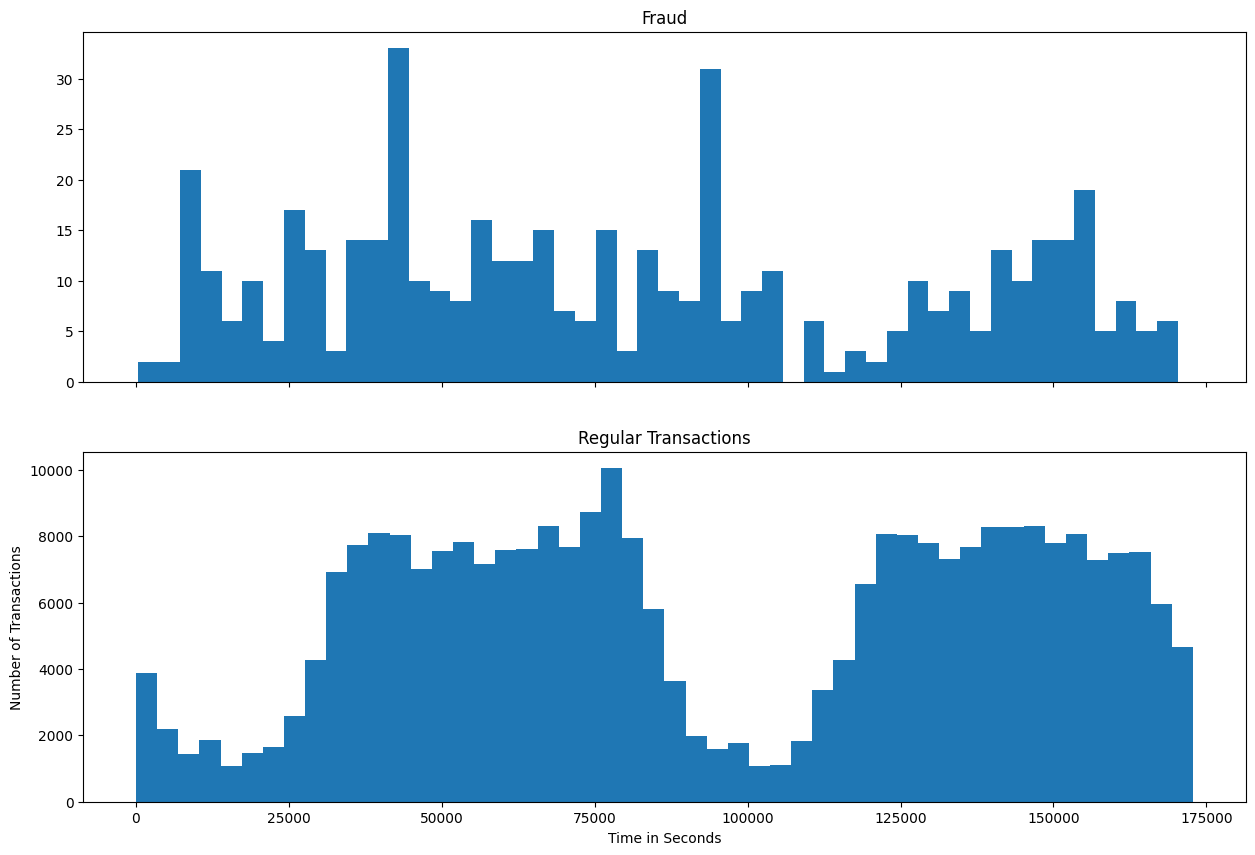

In [ ]:
plots, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))
bins = 50
ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')
ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Regular Transactions')
plt.xlabel('Time in Seconds')
plt.ylabel('Number of Transactions')
plt.show()

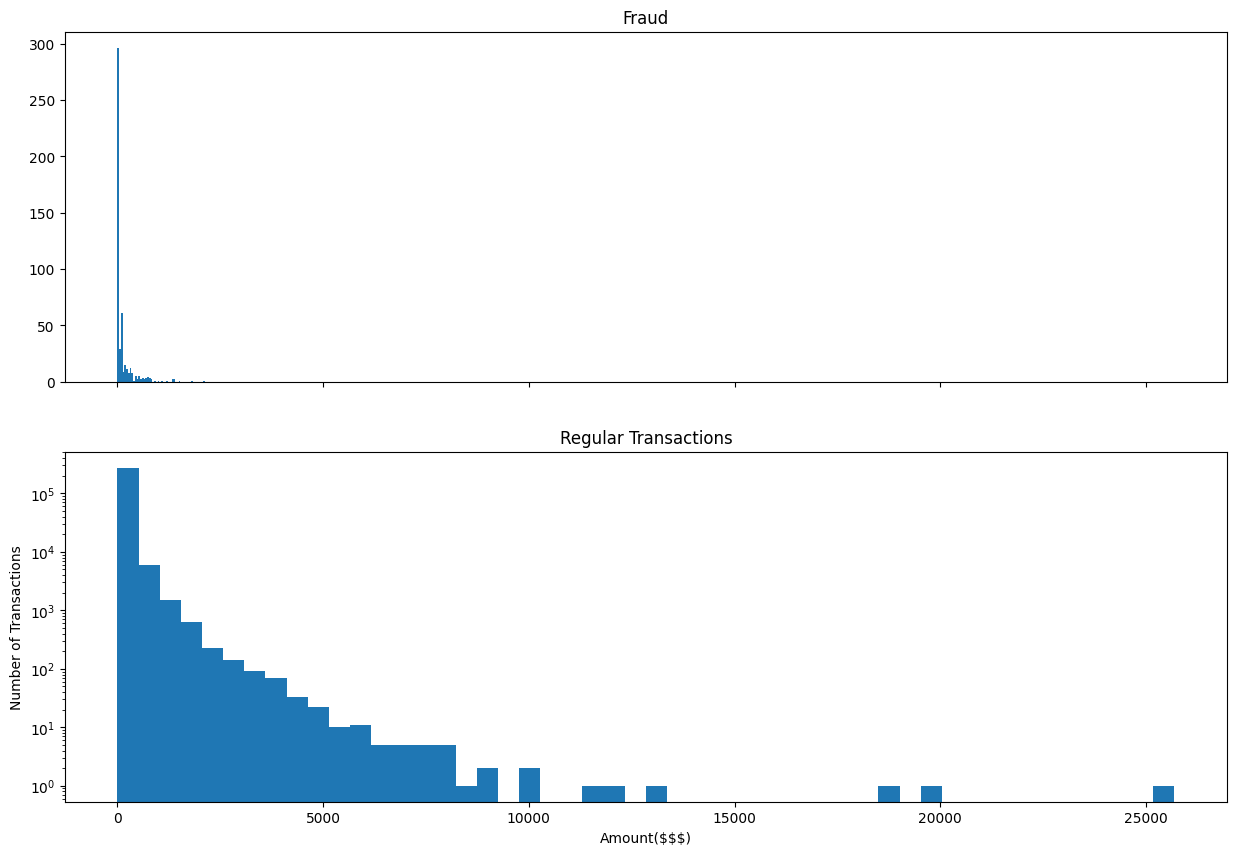

In [ ]:
plots, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))
bins = 50
ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')
ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Regular Transactions')
plt.xlabel('Amount($$$)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [ ]:
max_fraud_transaction = df[df.Class == 1]['Amount'].max()
print('$', max_fraud_transaction)

$ 2125.87


In [ ]:
#Data Analysis: Anonimized Features

In [ ]:
anonfeatures = df.iloc[:, 1:29]
print(anonfeatures.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V19       V20       V21       V22  \
0  0.098698  0.363787  0.090794  ...  0.403993  0.251412 -0.018307  0.277838   
1  0.085102 -0.255425 -0.166974  ... -0.145783 -0.069083 -0.225775 -0.638672   
2  0.247676 -1.514654  0.207643  ... -2.261857  0.524980  0.247998  0.771679   
3  0.377436 -1.387024 -0.054952  ... -1.232622 -0.208038 -0.108300  0.005274   
4 -0.270533  0.817739  0.753074  ...  0.803487  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  
0 -0

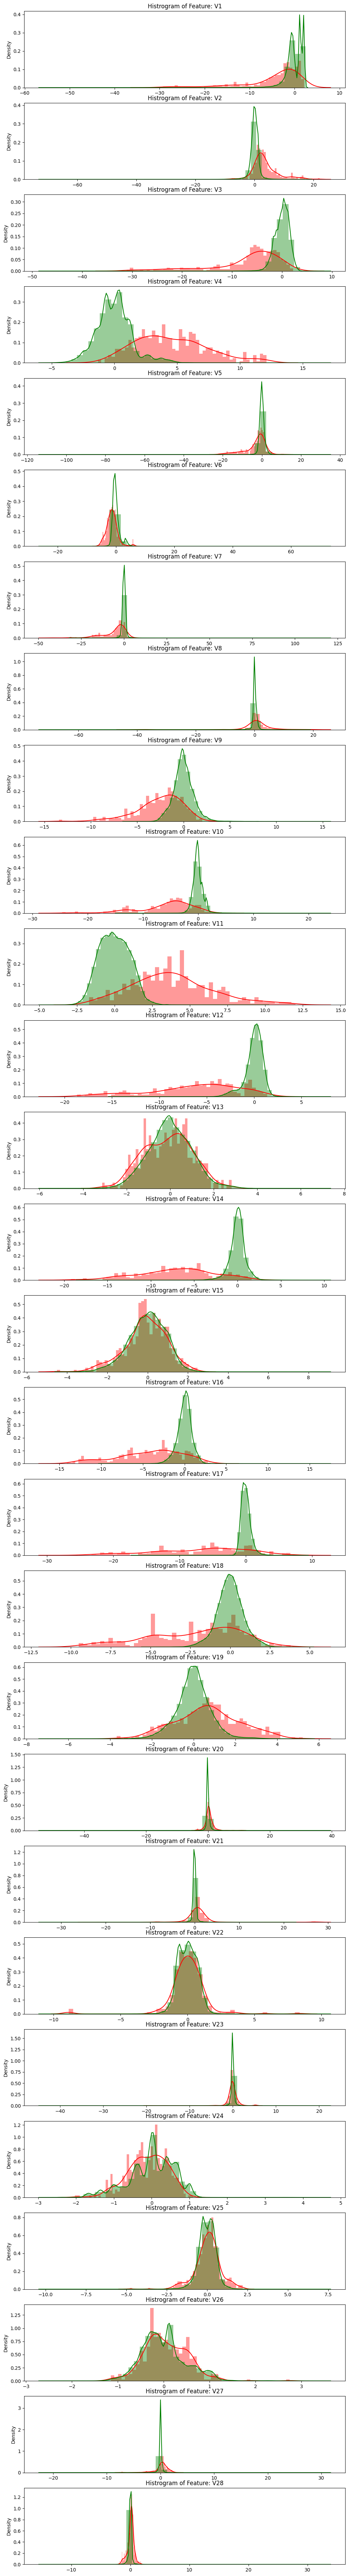

In [ ]:
plt.figure(figsize=(12,96))
grid = gridspec.GridSpec(28,1)
for i, col in enumerate(anonfeatures.columns):
    ax = plt.subplot(grid[i])
    sns.distplot(df[df.Class==1][col], bins=50, color='red')
    sns.distplot(df[df.Class==0][col], bins=50, color='green')
    ax.set_xlabel('')
    ax.set_title('Histrogram of Feature: ' + str(col))
plt.show()

In [ ]:
#Random Undersampling

In [ ]:
#Separating Dataframe for Testing (Over vs Undersamping)
stdScaler = StandardScaler()
robustScaler = RobustScaler()
df['scaled_amount'] = robustScaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = robustScaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

In [ ]:
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [ ]:
print('Fraud is', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Regular Transactions are', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
x = df.drop('Class', axis = 1).values
y = df['Class'].values

Fraud is 0.17 % of the dataset
Regular Transactions are 99.83 % of the dataset


In [ ]:
StratKF = StratifiedKFold(n_splits=5, shuffle = False, random_state = None)

In [ ]:
for train_index, test_index in StratKF.split(x, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = x[train_index], x[test_index]
    original_Ytrain, original_Ytest = y[train_index], y[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [ ]:
train_unique_label, train_counts_label = np.unique(original_Ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_Ytest, return_counts=True)
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label/ len(original_Ytrain))
print(test_counts_label/ len(original_Ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [ ]:
df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] #492 fraud class rows
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
249031,0.250821,0.816751,2.013071,-0.901185,-0.406748,-0.270479,-0.925027,-0.100641,-0.887242,0.049443,...,-0.515323,-0.554809,-1.106680,0.433646,-0.457981,-0.697470,-0.059506,0.004036,-0.042106,0
6971,24.979809,-0.888497,-3.499108,0.258555,-4.489558,4.853894,-6.974522,3.628382,5.431271,-1.946734,...,-3.042626,-1.052368,0.204817,-2.119007,0.170279,-0.393844,0.296367,1.985913,-0.900452,1
233300,1.444840,0.738096,1.717722,-1.062904,0.250901,0.578637,-1.485856,-0.224543,-1.067102,0.162454,...,-0.015929,0.275677,0.675010,0.161792,0.006397,-0.640576,0.506375,-0.013466,-0.015345,0
63634,1.089779,-0.398078,-9.169790,7.092197,-12.354037,4.243069,-7.176438,-3.386618,-8.058012,6.442909,...,0.816652,0.926157,-0.817706,-0.150434,-0.039383,0.485640,-0.264325,1.159690,0.232758,1
95597,18.615944,-0.226824,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,...,-0.447039,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1


In [ ]:
print(new_df['Class'].value_counts()/len(new_df))

Class
0    0.5
1    0.5
Name: count, dtype: float64


In [ ]:
X = new_df.drop('Class', axis = 1)
Y = new_df['Class']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
classifiers = {
    "LogisiticRegression": LogisticRegression(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42)}
for key, classifier in classifiers.items():
    classifier.fit(X_train, Y_train)
    trainingscore = cross_val_score(classifier, X_train, Y_train, cv=5)
    print("Classifier: ", classifier.__class__.__name__, "has a training score of", round(trainingscore.mean(), 2) * 100, "% accuracy.")

Classifier:  LogisticRegression has a training score of 94.0 % accuracy.
Classifier:  RandomForestClassifier has a training score of 94.0 % accuracy.
[LightGBM] [Info] Number of positive: 330, number of negative: 358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6884
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479651 -> initscore=-0.081440
[LightGBM] [Info] Start training from score -0.081440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
#GridSearchCV
logreg_paramgrid = {'C': [0.001,0.01,0.1,1,10,100,1000]}
rf_paramgrid = {'n_estimators': [1,2,3,4,5,6,7,8,9,10], 'max_depth' : [1,2,3,4,5,6,7,8]}
lgbm_paramgrid = {'n_estimators': [1,2,3,4,5,6,7,8,9,10], 'learning_rate': [0.01,0.05,0.1,0.2,0.3]}
dt_paramgrid = {'max_depth': [1,2,3,4,5,6,7,8], 'min_samples_leaf': [1,2,3,4,5,6]}
paramgrids = {'LogisticRegression': logreg_paramgrid, 'RandomForestClassifier': rf_paramgrid, 'LGBMClassifier': lgbm_paramgrid, 'DecisionTreeClassifier': dt_paramgrid}

In [ ]:
gridsearch_results = {}
for key, classifier in classifiers.items():
    gridsearch = GridSearchCV(classifier, paramgrids[classifier.__class__.__name__], cv=5)
    gridsearch.fit(X_train, Y_train)
    gridsearch_results[key] = gridsearch
#Find Best Estimators
for key, classifier in classifiers.items():
    print("Classifier: ", classifier.__class__.__name__, "has a best estimator of", gridsearch_results[key].best_estimator_)

[LightGBM] [Info] Number of positive: 264, number of negative: 286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5470
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480000 -> initscore=-0.080043
[LightGBM] [Info] Start training from score -0.080043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 264, number of negative: 286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5463
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480000 -> initscore=-0.080043
[Li

In [ ]:
logreg = LogisticRegression(C=0.1, random_state=42)
rforest = RandomForestClassifier(max_depth=2, n_estimators=5, random_state=42)
lgbm = LGBMClassifier(learning_rate=0.2, n_estimators=9, random_state=42)
dtree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)

In [ ]:
logreg_score = cross_val_score(logreg, X_train, Y_train, cv=5)
rforest_score = cross_val_score(rforest, X_train, Y_train, cv=5)
lgbm_score = cross_val_score(lgbm, X_train, Y_train, cv=5)
dtree_score = cross_val_score(dtree, X_train, Y_train, cv=5)
print("Logistic Regression CV Score:", round(logreg_score.mean()*100,2).astype(str)+'%')
print("Random Forest CV Score:", round(rforest_score.mean()*100,2).astype(str)+'%')
print("LightGBM CV Score:", round(lgbm_score.mean()*100,2).astype(str)+'%')
print("Decision Tree CV Score:", round(dtree_score.mean()*100,2).astype(str)+'%')

[LightGBM] [Info] Number of positive: 264, number of negative: 286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5470
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480000 -> initscore=-0.080043
[LightGBM] [Info] Start training from score -0.080043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
#Undersampling
X_undersample = df.drop('Class', axis = 1)
Y_undersample = df['Class']
for train_index, test_index in StratKF.split(X_undersample, Y_undersample):
    print("Train:", train_index, "Test:", test_index)
    X_train_undersample, X_test_undersample = X_undersample.iloc[train_index], X_undersample.iloc[test_index]
    Y_train_undersample, Y_test_undersample = Y_undersample.iloc[train_index], Y_undersample.iloc[test_index]
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []
X_nearmiss, Y_nearmiss = NearMiss().fit_resample(X_train_undersample, Y_train_undersample)
print('Nearmiss Distribution: {}'.format(Counter(Y_nearmiss)))

Train: [ 48639  48791  48847 ... 284804 284805 284806] Test: [    0     1     2 ... 56977 56978 56979]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 48639  48791  48847 ... 113948 113949 113950]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 94589  94636  95202 ... 170889 170890 170891]
Train: [     0      1      2 ... 284804 284805 284806] Test: [167625 167831 170021 ... 227846 227847 227848]
Train: [     0      1      2 ... 227846 227847 227848] Test: [226254 226932 227725 ... 284804 284805 284806]
Nearmiss Distribution: Counter({0: 394, 1: 394})


In [ ]:
# for train,test in StratKF.split(X_train_undersample, Y_train_undersample):
  #undersample_main = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), logreg)
  #undersample_model = undersample_main.fit(X_train_undersample.iloc[train], Y_train_undersample.iloc[train])
  #undersample_predict = undersample_model.predict(X_train_undersample.iloc[test])
  #undersample_accuracy.append(undersample_main.score(original_Xtrain[test], original_Ytrain[test]))
  #undersample_precision.append(precision_score(original_Ytrain[test], undersample_predict))
  #undersample_recall.append(recall_score(original_Ytrain[test], undersample_predict))
  #undersample_f1.append(f1_score(original_Ytrain[test], undersample_predict))
  #undersample_auc.append(roc_auc_score(original_Ytrain[test], undersample_predict))

#print("Average Accuracy:", np.mean(undersample_accuracy))
#print("Average Precision:", np.mean(undersample_precision))
#print("Average Recall:", np.mean(undersample_recall))
#print("Average F1:", np.mean(undersample_f1))
#print("Average AUC:", np.mean(undersample_auc))

[LightGBM] [Info] Number of positive: 264, number of negative: 286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5470
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480000 -> initscore=-0.080043
[LightGBM] [Info] Start training from score -0.080043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

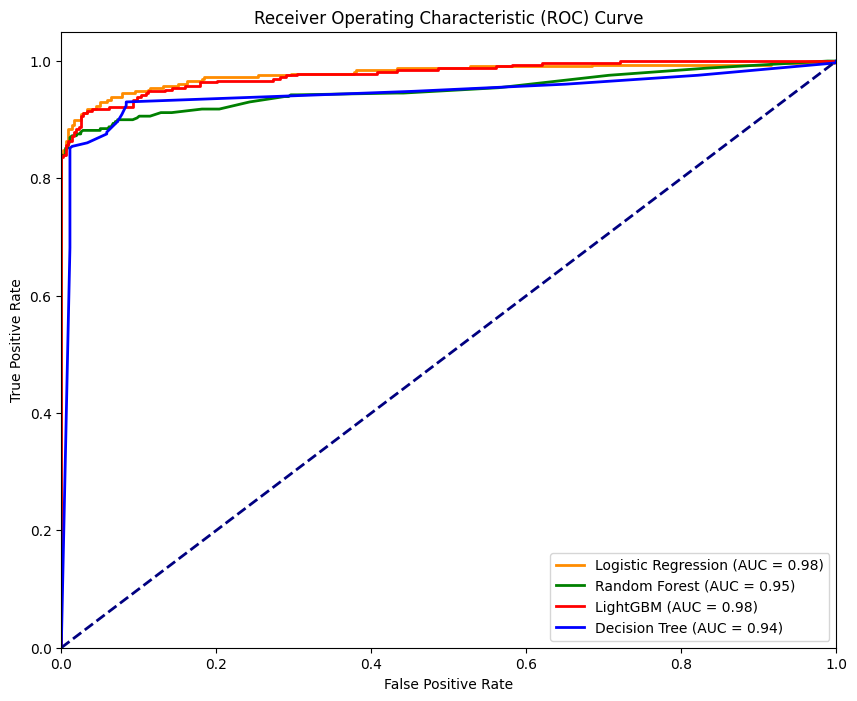

In [ ]:
#ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
logreg_probs = cross_val_predict(logreg, X_train, Y_train, cv=5, method='predict_proba')[:,1]
rforest_probs = cross_val_predict(rforest, X_train, Y_train, cv=5, method='predict_proba')[:,1]
lgbm_probs = cross_val_predict(lgbm, X_train, Y_train, cv=5, method='predict_proba')[:,1]
dtree_probs = cross_val_predict(dtree, X_train, Y_train, cv=5, method='predict_proba')[:,1]
logreg_fpr, logreg_tpr, _ = roc_curve(Y_train, logreg_probs)
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)
rforest_fpr, rforest_tpr, _ = roc_curve(Y_train, rforest_probs)
rforest_roc_auc = auc(rforest_fpr, rforest_tpr)
lgbm_fpr, lgbm_tpr, _ = roc_curve(Y_train, lgbm_probs)
lgbm_roc_auc = auc(lgbm_fpr, lgbm_tpr)
dtree_fpr, dtree_tpr, _ = roc_curve(Y_train, dtree_probs)
dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

plt.figure(figsize=(10, 8))
plt.plot(logreg_fpr, logreg_tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {logreg_roc_auc:.2f})')
plt.plot(rforest_fpr, rforest_tpr, color='green', lw=2, label=f'Random Forest (AUC = {rforest_roc_auc:.2f})')
plt.plot(lgbm_fpr, lgbm_tpr, color='red', lw=2, label=f'LightGBM (AUC = {lgbm_roc_auc:.2f})')
plt.plot(dtree_fpr, dtree_tpr, color='blue', lw=2, label=f'Decision Tree (AUC = {dtree_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Over-Sampling: SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [ ]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_Ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_Ytest)))

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961


In [ ]:
acc_S = []
prec_S = []
rec_S = []
f1_S = []
auc_S = []

logregS_paramgrid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
logreg_S = LogisticRegression(random_state=42)
rand_logreg_S = RandomizedSearchCV(logreg_S, logregS_paramgrid, n_iter=2, random_state=42)
StratKFSMOTE = StratifiedKFold(n_splits=3, shuffle = False, random_state = None)

In [ ]:
for train, test in StratKFSMOTE.split(original_Xtrain, original_Ytrain):
    smote_pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_logreg_S)
    smote_model = smote_pipeline.fit(original_Xtrain[train], original_Ytrain[train])
    smote_best = rand_logreg_S.best_estimator_
    smote_predict = smote_best.predict(original_Xtrain[test])
    acc_S.append(smote_pipeline.score(original_Xtrain[test], original_Ytrain[test]))
    prec_S.append(precision_score(original_Ytrain[test], smote_predict))
    rec_S.append(recall_score(original_Ytrain[test], smote_predict))
    f1_S.append(f1_score(original_Ytrain[test], smote_predict))
    auc_S.append(roc_auc_score(original_Ytrain[test], smote_predict))

In [ ]:
# Print average performance metrics
print("Average Accuracy:", np.mean(acc_S))
print("Average Precision:", np.mean(prec_S))
print("Average Recall:", np.mean(rec_S))
print("Average F1:", np.mean(f1_S))
print("Average AUC:", np.mean(auc_S))

Average Accuracy: 0.9541006478988056
Average Precision: 0.05540126074966623
Average Recall: 0.87323617857969
Average F1: 0.10164011354667685
Average AUC: 0.9137386444995007


In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, Ysm_train = sm.fit_resample(original_Xtrain, original_Ytrain)
logreg_sm = rand_logreg_S.best_estimator_
logreg_sm.fit(Xsm_train, Ysm_train)

LogisticRegression(C=0.001, random_state=42)

In [ ]:
#Neural Network Evaluations (Undersampling vs. Oversampling)

In [ ]:
#Undersample

In [ ]:
n_inputs = X_train.shape[1]

undersample_model = Sequential([
  Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
  Dense(32, activation='relu'),
  Dense(2, activation='softmax')
  ])

undersample_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,988 (7.77 KB)

 Trainable params: 1,988 (7.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
undersample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(X_train, Y_train, validation_split=0.2, epochs=30, shuffle=True, verbose=2, batch_size=32)

Epoch 1/30
18/18 - 1s - 69ms/step - accuracy: 0.6509 - loss: 0.5575 - val_accuracy: 0.8261 - val_loss: 0.4156
Epoch 2/30
18/18 - 0s - 5ms/step - accuracy: 0.8745 - loss: 0.3571 - val_accuracy: 0.8623 - val_loss: 0.3355
Epoch 3/30
18/18 - 0s - 8ms/step - accuracy: 0.9291 - loss: 0.2712 - val_accuracy: 0.8841 - val_loss: 0.2972
Epoch 4/30
18/18 - 0s - 7ms/step - accuracy: 0.9345 - loss: 0.2234 - val_accuracy: 0.8986 - val_loss: 0.2739
Epoch 5/30
18/18 - 0s - 8ms/step - accuracy: 0.9364 - loss: 0.1885 - val_accuracy: 0.9130 - val_loss: 0.2617
Epoch 6/30
18/18 - 0s - 16ms/step - accuracy: 0.9400 - loss: 0.1645 - val_accuracy: 0.9275 - val_loss: 0.2616
Epoch 7/30
18/18 - 0s - 8ms/step - accuracy: 0.9509 - loss: 0.1461 - val_accuracy: 0.9348 - val_loss: 0.2554
Epoch 8/30
18/18 - 0s - 8ms/step - accuracy: 0.9527 - loss: 0.1326 - val_accuracy: 0.9275 - val_loss: 0.2568
Epoch 9/30
18/18 - 0s - 17ms/step - accuracy: 0.9582 - loss: 0.1230 - val_accuracy: 0.9348 - val_loss: 0.2550
Epoch 10/30
18/1

In [ ]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[54959  1904]
 [    6    92]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


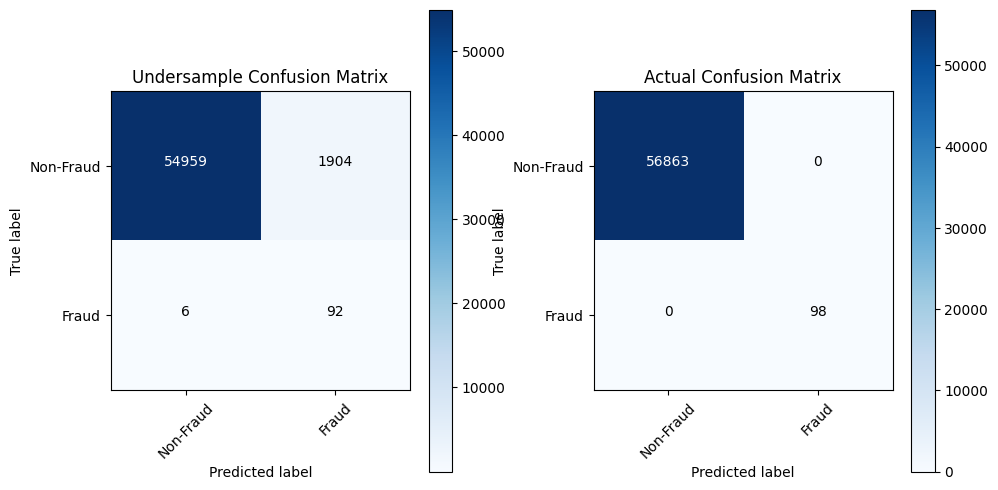

In [ ]:
undersample_fraud_predictions = undersample_fraud_predictions.astype(int)
undersample_cm = confusion_matrix(original_Ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_Ytest, original_Ytest)
labels = ['Non-Fraud', 'Fraud']
figure = plt.figure(figsize=(10, 10))
figure.add_subplot(221)
plot_confusion_matrix(undersample_cm, classes=labels, title="Undersample Confusion Matrix")
figure.add_subplot(222)
plot_confusion_matrix(actual_cm, classes=labels, title="Actual Confusion Matrix")
plt.show()

In [ ]:
#Oversample

In [ ]:
nsm_inputs = Xsm_train.shape[1]

In [ ]:
oversample_model = Sequential([
  Dense(nsm_inputs, input_shape=(nsm_inputs, ), activation='relu'),
  Dense(32, activation='relu'),
  Dense(2, activation='softmax')
  ])

oversample_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,988 (7.77 KB)

 Trainable params: 1,988 (7.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
oversample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(Xsm_train, Ysm_train,validation_split=0.2, epochs=5, shuffle=True, verbose=2, batch_size=32)

Epoch 1/5
11373/11373 - 25s - 2ms/step - accuracy: 0.9989 - loss: 0.0045 - val_accuracy: 0.9974 - val_loss: 0.0086
Epoch 2/5
11373/11373 - 22s - 2ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 3/5
11373/11373 - 23s - 2ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9998 - val_loss: 0.0017
Epoch 4/5
11373/11373 - 22s - 2ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9997 - val_loss: 0.0017
Epoch 5/5
11373/11373 - 41s - 4ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 8.0969e-04


In [ ]:
oversample_preds = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56840    23]
 [   24    74]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


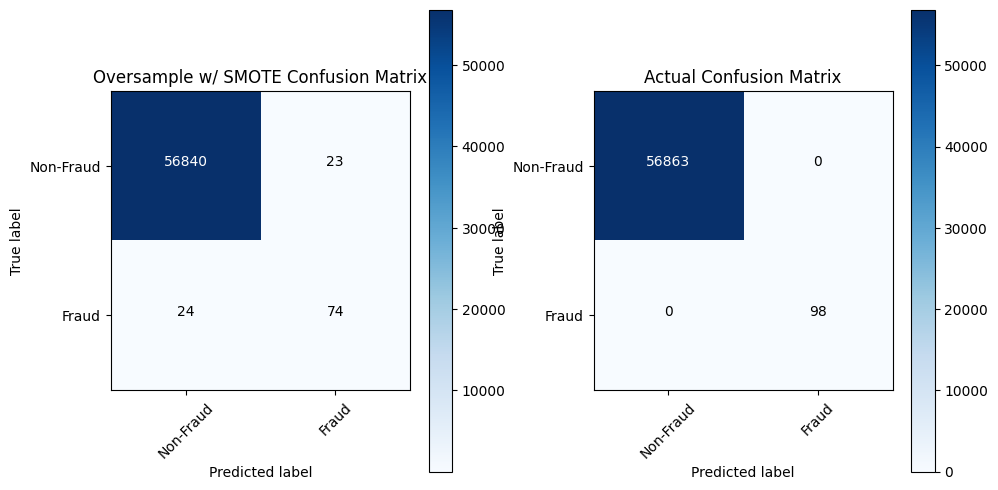

In [ ]:
oversample_fraud_preds = np.argmax(oversample_model.predict(original_Xtest, batch_size=200, verbose=0), axis=1)
oversample_smote = confusion_matrix(original_Ytest, oversample_fraud_preds)
actual_cm = confusion_matrix(original_Ytest, original_Ytest)
labels = ['Non-Fraud', 'Fraud']
figure = plt.figure(figsize=(10, 10))
figure.add_subplot(221)
plot_confusion_matrix(oversample_smote, classes=labels, title="Oversample w/ SMOTE Confusion Matrix")
figure.add_subplot(222)
plot_confusion_matrix(actual_cm, classes=labels, title="Actual Confusion Matrix")
plt.show()

In [ ]:
#Evaluation: Summary Statistics

In [ ]:
#Neural Network w/ Keras: Undersampling

In [ ]:
tn, fp, fn, tp = undersample_cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

roc_auc = roc_auc_score(original_Ytest, undersample_fraud_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.9665
Precision: 0.0461
Recall: 0.9388
F1 Score: 0.0879
ROC AUC: 0.9526


In [ ]:
#Neural Network w/ Keras: Oversampling ft. SMOTE

In [ ]:
tnsm, fpsm, fnsm, tpsm = oversample_smote.ravel()

accuracy = (tpsm + tnsm) / (tpsm + tnsm + fpsm + fnsm)
precision = tpsm / (tpsm + fpsm) if (tpsm + fpsm) > 0 else 0
recall = tpsm / (tpsm + fnsm) if (tpsm + fnsm) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

roc_auc = roc_auc_score(original_Ytest, undersample_fraud_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9992
Precision: 0.7629
Recall: 0.7551
F1 Score: 0.7590
ROC AUC: 0.9526


In [ ]:
#Oversampling scores better metrics and allows for the model to have an F1 score of 76% and an accuracy metric of 99.92% when trying to positively identify fraudulent transactions.
#This shows is it the optimal model going forward for fraud identification.